In [1]:
#https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

from model import *

In [2]:
train_path = r'data/avy/train'
test_path = r'data/avy/test'

## Data cleaning

In [3]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (160, 160), method="nearest")
    input_mask = tf.image.resize(input_mask, (160, 160), method="nearest")

    return input_image, input_mask

def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image_train(datapoint):
    input_image = io.imread(os.path.join(train_path, 'image', "%d.TIF"%datapoint), as_gray = False, plugin = 'tifffile')#datapoint["image"]
    input_mask = io.imread(os.path.join(train_path, 'label', "%d.TIF"%datapoint), as_gray = True, plugin = 'tifffile')#datapoint["segmentation_mask"]
    input_mask = np.reshape(input_mask,input_mask.shape+(1,))
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = io.imread(os.path.join(test_path, "%d.TIF"%datapoint))#datapoint["image"]
    input_mask = io.imread(os.path.join(test_path, 'label', "%d.TIF"%datapoint))#datapoint["segmentation_mask"]
    input_mask = np.reshape(input_mask,input_mask.shape+(1,))
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [198]:
# #tst = tf.data.Dataset.from_tensor_slices(train_num).map(lambda x: tf.py_function(load_image_train(x)))
# #tf.data.Dataset.from_tensor_slices(train_num).map(lambda x: x.numpy())
# #dataset = tf.data.Dataset.from_tensor_slices(train_num)
# #dataset.map(lambda x: print(int(x)))
def load_image_train(train_f, test_f):
    input_image = tf.io.read_file(train_f)
    input_mask = tf.io.read_file(test_f)
    #input_mask = np.reshape(input_mask,input_mask.shape+(1,))
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

tst_train = tf.data.Dataset.list_files(os.path.join(train_path, r'image', r"*.TIF"))
tst_test = tf.data.Dataset.list_files(os.path.join(train_path, r'image/label', r"*.TIF"))

tst_dataset = tst.map(load_image_train)

# tst_input_mask = tf.io.read_file(os.path.join(train_path, r'image', r"0.TIF"))
# #tst_input_mask = tf.reshape(tst_input_mask,tst_input_mask.shape+(1,))
# print(tf.shape(tst_input_mask).numpy())

TypeError: in user code:


    TypeError: tf__load_image_train() missing 1 required positional argument: 'test_f'


In [20]:
train_num = list(map(lambda x: int(x.split('.TIF')[0]), os.listdir(os.path.join(train_path, 'image'))))
listing = glob.glob(os.path.join(test_path,'*[0-9].TIF'))
test_num = list(map(lambda x: int(x.split('.TIF')[0].split('\\')[1]), listing))

#train_dataset = list(map(load_image_train, train_num))#, num_parallel_calls=tf.data.AUTOTUNE)
#test_dataset = list(map(load_image_test, test_num))#, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = tf.data.Dataset.from_generator(lambda: map(load_image_train, train_num),
                                               output_signature=(
                                                   tf.TensorSpec(shape=(160,160,3), dtype=tf.float32),
                                                   tf.TensorSpec(shape=(160,160,1), dtype=tf.uint8)))
test_dataset = tf.data.Dataset.from_generator(lambda: map(load_image_test, test_num),
                                              output_signature=(
                                                  tf.TensorSpec(shape=(160,160,3), dtype=tf.float32),
                                                  tf.TensorSpec(shape=(160,160,1), dtype=tf.uint8)))

## Modeling

In [21]:
BATCH_SIZE = 30
BUFFER_SIZE = 500
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(1000).take(151).batch(BATCH_SIZE)

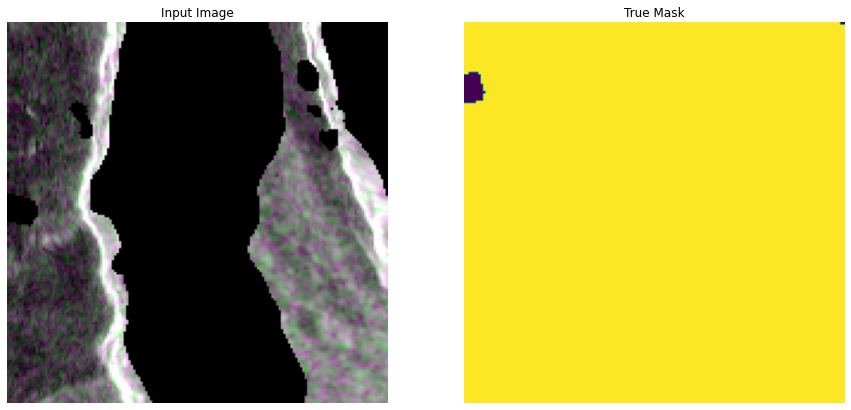

In [24]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [25]:
unet_model = unet()
model_checkpoint = ModelCheckpoint('unet_avy_2.hdf5', monitor='loss',verbose=1, save_best_only=True)
# unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
#                   loss="sparse_categorical_crossentropy",
#                   metrics="accuracy")

C:\Users\cdelannoy\AppData\Local\Continuum\Anaconda3\envs\tsflow\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
NUM_EPOCHS = 2

TRAIN_LENGTH = len(train_num)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = len(test_num)
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=test_batches,
                               callbacks = [model_checkpoint])

Epoch 1/2
 68/141 [=============>................] - ETA: 43:22 - loss: nan - accuracy: 0.0857